<a href="https://colab.research.google.com/github/azganushpoghosyan/fidap/blob/main/NYC_neighborhoods_with_potential_demand_for_fitness_centers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this analysis we are going to find neighborhoods in NYC with a potential need for fitness centers/gym. The methodology is as follows:
We will first find out the current locations of fitness centers and see how they are distributed. Then we will analyze the demographics in those areas and will also consider the insights on fitness demographics from this [report](https://runrepeat.com/gym-membership-statistics).
Then we will find the areas with the lowest level of access to fitness centers and will concentrate on our target demographics. Based on the latter we will suggest several top neighborhoods with a potential demand for fitness centers.

Instantiate api connection and import necesary libraries

In [ ]:
!pip install --upgrade fidap
!pip install geopandas

from fidap import fidap_client
fidap = fidap_client(api_key='e5bb3c8567d14dd28923d1cdbe0560a4')

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from functools import reduce

---
First, let's understand NYC zipcode boundaries and each zip code's area in square miles. 

We will find this information in  Fidap's [US Boundaries](https://app.fidap.com/catalog/datasets/293/tables) dataset, using NY State's and NYC Counties FIPS Codes ([NYC zip codes](https://www.unitedstateszipcodes.org/#zips-list))

In [251]:
nyc_zip_boundary = fidap.sql("""
SELECT zip_code, zip_code_geom, (ROUND(ST_AREA(zip_code_geom)/2589988.1103,3)) AS zip_area_sqm
FROM bigquery-public-data.geo_us_boundaries.zip_codes
WHERE  zip_code LIKE '100%' OR zip_code LIKE '101%' OR zip_code LIKE '102%' OR zip_code LIKE '103%' OR zip_code LIKE '104%' OR
       zip_code LIKE '110%' OR zip_code LIKE '111%' OR zip_code LIKE '112%' OR zip_code LIKE '113%' OR zip_code LIKE '114%' OR
       zip_code LIKE '116%'
""")

Check the [query](https://app.fidap.com/queries/query-builder?q_id=159) in Fidap

In [252]:
nyc_zip_boundary.head()

,zip_code,zip_code_geom,zip_area_sqm
0,11359,"POLYGON((-73.78332 40.794788, -73.783318 40.79...",0.250
1,10006,"POLYGON((-74.015834 40.706984, -74.015956 40.7...",0.093
2,11370,"MULTIPOLYGON(((-73.892656 40.793824, -73.89276...",1.488
3,11005,"POLYGON((-73.721424 40.75653, -73.721489 40.75...",0.183
4,10024,"POLYGON((-73.98814 40.781409, -73.987414 40.78...",0.857


Then let's find out the locations of current NYC fitness centers/gym using Fidap's [OpenStreetMap](https://app.fidap.com/catalog/datasets/292/tables) dataset. We will search fitness centers with the following keys: ***leisure, sport, amenity*** and the following values: ***fitness_centre, fitness_station, sports_centre, fitness, gym***

In [253]:
fitness_query = fidap.sql("""
WITH bounding_area AS 
    (SELECT geometry 
     FROM bigquery-public-data.geo_openstreetmap.planet_features_multipolygons
     WHERE ('name:en', 'New York') IN (SELECT(key, value) FROM UNNEST(all_tags))
    )
SELECT pt.geometry, tags.value AS tags, tags.key AS keys
FROM bigquery-public-data.geo_openstreetmap.planet_features_points AS pt, bounding_area
JOIN UNNEST(all_tags) AS tags
WHERE (tags.key = 'name' OR tags.key = 'addr:postcode')
AND (('leisure', 'fitness_centre') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR 
     ('leisure', 'fitness_station') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR
     ('leisure', 'sports_centre') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR 
     ('sport', 'fitness') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR
     ('sport', 'gym') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR 
     ('amenity', 'gym') IN (SELECT(key, value) FROM UNNEST(all_tags)) OR
     ('amenity', 'sports_centre') IN (SELECT(key, value) FROM UNNEST(all_tags)))
AND ST_WITHIN(pt.geometry, bounding_area.geometry)
""").drop_duplicates()

In [254]:
fitness_query.head()

,geometry,tags,keys
0,POINT(-73.9807358 40.7709004),10023,addr:postcode
1,POINT(-73.9807358 40.7709004),TOP OF THE ONE,name
2,POINT(-73.9717552 40.7918388),10025,addr:postcode
3,POINT(-73.9717552 40.7918388),X93 Fitness,name
4,POINT(-76.0693427 43.0438318),13214,addr:postcode


Let's pivot the table and have name and zip codes in separate columns

In [255]:
fitness_df = fitness_query.pivot(index = ['geometry'], columns = 'keys', values = 'tags').reset_index()
fitness_df = fitness_df.rename(columns = {'addr:postcode' : 'zip_code'})
fitness_df.name = fitness_df.name.fillna('Unknown')

In [256]:
fitness_df.head()

keys,geometry,zip_code,name
0,POINT(-71.9489157 41.0323466),11954,Puff 'n' Putt
1,POINT(-72.1571508 40.9770687),NaN,Sportime Tennis Club
2,POINT(-72.8406817 40.9431229),NaN,Defined Fitness
3,POINT(-72.94069 40.9459881),NaN,Crossfit 631
4,POINT(-72.9888266 40.8490897),NaN,Country Point Gym


Now let's find the number of fitness centers per zip_code

In [257]:
fitness_df_zip = fitness_df.groupby(['zip_code'])['name'].agg('count').reset_index()
fitness_df_zip.rename(columns = {'name': 'fitness_centers_count'}, inplace = True)
fitness_df_zip.zip_code = fitness_df_zip.zip_code.astype(int)

In [258]:
fitness_df_zip.head()

,zip_code,fitness_centers_count
0,10001,4
1,10002,6
2,10003,4
3,10004,1
4,10005,3


We will join this dataset on zip_code to the nyc zip_code boundary dataset and will create a geo dataframe from it so that we can visualize the data on a map.

In [259]:
fitness_df_zip = fitness_df_zip.merge(nyc_zip_boundary, how = 'right', on = 'zip_code')
fitness_df_zip.zip_code_geom = fitness_df_zip.zip_code_geom.apply(str).apply(wkt.loads)
fitness_df_zip.fitness_centers_count = fitness_df_zip.fitness_centers_count.fillna(0)
fitness_gdf_zip = gpd.GeoDataFrame(fitness_df_zip, geometry = 'zip_code_geom', crs = 'epsg:4326')

In [260]:
fitness_gdf_zip.head()

,zip_code,fitness_centers_count,zip_code_geom,zip_area_sqm
0,11359,0.0,"POLYGON ((-73.78332 40.79479, -73.78332 40.794...",0.250
1,10006,0.0,"POLYGON ((-74.01583 40.70698, -74.01596 40.706...",0.093
2,11370,0.0,"MULTIPOLYGON (((-73.89266 40.79382, -73.89277 ...",1.488
3,11005,0.0,"POLYGON ((-73.72142 40.75653, -73.72149 40.756...",0.183
4,10024,4.0,"POLYGON ((-73.98814 40.78141, -73.98741 40.781...",0.857


Now let's the the data on a map.

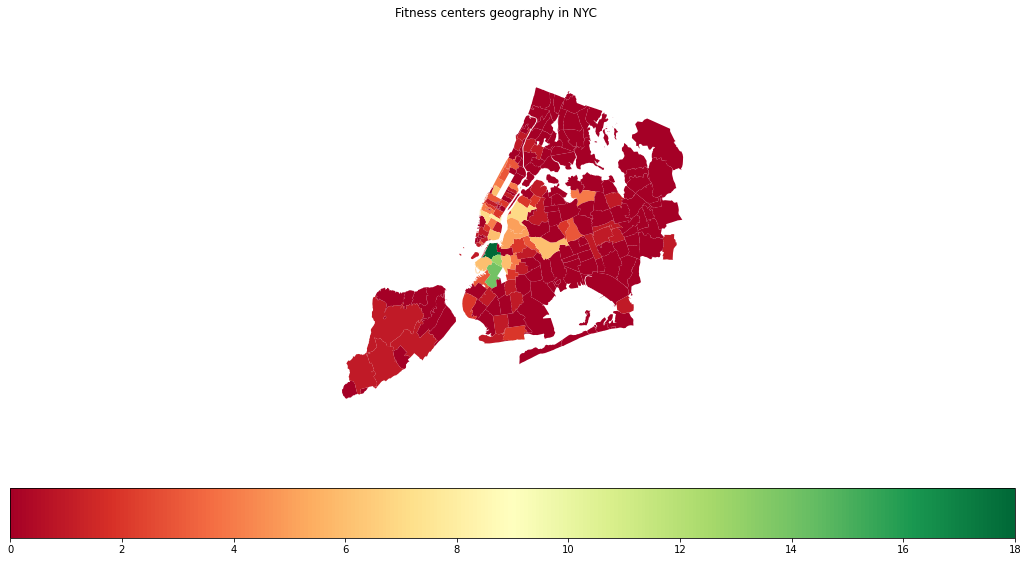

In [262]:
fig, ax = plt.subplots(figsize = (18, 9))
fitness_gdf_zip.plot(ax = ax, column = 'fitness_centers_count', cmap = 'RdYlGn', legend = True, legend_kwds = {'orientation':'horizontal'})
fig.suptitle("Fitness centers geography in NYC")
ax.set_axis_off()
plt.show()

We can see that that certain neighborhoods in Brooklyn have the highest number of fitness clubs. 

Let's understand the demographics of NYC. We are particularly interested in age groups and race.

In [165]:
nyc_racial_distribution = fidap.sql("""
SELECT DISTINCT geo_id AS zip_code,
hispanic_pop AS hispanic_latinx, 
white_pop AS white, 
black_pop AS black, 
amerindian_pop AS indigenous,
asian_pop AS asian, 
total_pop - (hispanic_pop + white_pop + black_pop + amerindian_pop + asian_pop) AS other
FROM bigquery-public-data.census_bureau_acs.zcta5_2018_5yr
WHERE geo_id LIKE '100%' OR geo_id LIKE '101%' OR geo_id LIKE '102%' OR geo_id LIKE '103%' OR geo_id LIKE '104%' OR
      geo_id LIKE '110%' OR geo_id LIKE '111%' OR geo_id LIKE '112%' OR geo_id LIKE '113%' OR geo_id LIKE '114%' OR
      geo_id LIKE '116%'
""")

In [166]:
nyc_racial_distribution.head()

,zip_code,hispanic_latinx,white,black,indigenous,asian,other
0,10464,1117,2966,83,0,245,23
1,11024,842,6569,121,0,414,155
2,10471,5003,12819,2276,0,1262,536
3,11210,4716,19773,38113,23,2828,1587
4,11232,13974,6141,1372,91,5268,756


In [140]:
nyc_age_distribution = fidap.sql("""
SELECT DISTINCT geo_id AS zip_code, total_pop, male_pop, female_pop, median_age,
(male_under_5 + male_5_to_9 + male_10_to_14 + male_15_to_17 + female_under_5 + female_5_to_9 + female_10_to_14 + female_15_to_17) AS total_under_18,
(male_18_to_19 + male_20 + male_21 + male_22_to_24 + male_25_to_29 + male_30_to_34 + male_18_to_19 + female_20 + female_21 + female_22_to_24 + female_25_to_29 + female_30_to_34) AS total_18_34,
(male_35_to_39 + male_40_to_44 + male_45_to_49 + male_50_to_54 + female_35_to_39 + female_40_to_44 + female_45_to_49 + female_50_to_54) AS total_35_54,
(male_55_to_59 + male_60_to_61 + male_62_to_64 + female_55_to_59 + female_60_to_61 + female_62_to_64) AS total_55_64,
(male_65_to_66 + male_67_to_69 + male_70_to_74 + male_75_to_79 + male_80_to_84 + male_85_and_over + female_65_to_66 + female_67_to_69 + female_70_to_74 + female_75_to_79 + female_80_to_84 + female_85_and_over) AS total_over_65
FROM bigquery-public-data.census_bureau_acs.zcta5_2018_5yr
WHERE geo_id LIKE '100%' OR geo_id LIKE '101%' OR geo_id LIKE '102%' OR geo_id LIKE '103%' OR geo_id LIKE '104%' OR
      geo_id LIKE '110%' OR geo_id LIKE '111%' OR geo_id LIKE '112%' OR geo_id LIKE '113%' OR geo_id LIKE '114%' OR
      geo_id LIKE '116%'
""")

In [141]:
nyc_age_distribution.head()

,zip_code,total_pop,male_pop,female_pop,median_age,total_under_18,total_18_34,total_35_54,total_55_64,total_over_65
0,10464,4434,2162,2272,44.9,770,984,1156,501,997
1,11024,8101,4481,3620,31.4,2353,2165,1455,974,1269
2,10471,21896,10378,11518,44.9,3473,4736,4959,3011,5554
3,11210,67040,30595,36445,35.6,17967,14897,16934,8279,8892
4,11232,27602,14304,13298,33.8,5902,8677,8551,2308,2212


In [142]:
nyc_income_distribution = fidap.sql("""
SELECT DISTINCT geo_id AS zip_code, income_per_capita, median_income,
(income_less_10000 + income_10000_14999 + income_15000_19999) AS income_less_20000,
(income_20000_24999 + income_25000_29999 + income_30000_34999 + income_35000_39999) AS income_20000_39999,
(income_40000_44999 + income_45000_49999 + income_50000_59999) AS income_40000_59999,
(income_60000_74999 + income_75000_99999) AS income_60000_99999,
(income_100000_124999 + income_125000_149999) AS income_100000_149999,
(income_150000_199999 + income_200000_or_more) AS income_150000_more
FROM bigquery-public-data.census_bureau_acs.zcta5_2018_5yr
WHERE geo_id LIKE '100%' OR geo_id LIKE '101%' OR geo_id LIKE '102%' OR geo_id LIKE '103%' OR geo_id LIKE '104%' OR
      geo_id LIKE '110%' OR geo_id LIKE '111%' OR geo_id LIKE '112%' OR geo_id LIKE '113%' OR geo_id LIKE '114%' OR
      geo_id LIKE '116%'
""")

In [143]:
nyc_income_distribution.head()

,zip_code,income_per_capita,median_income,income_less_20000,income_20000_39999,income_40000_59999,income_60000_99999,income_100000_149999,income_150000_more
0,10464,49875.0,93365.0,210,242,214,326,376,525
1,11024,53709.0,106250.0,116,94,225,518,341,765
2,10471,49313.0,85707.0,1122,1079,909,1886,1590,2012
3,11210,30110.0,65900.0,3010,3433,3847,5446,3342,3189
4,11232,26865.0,56661.0,1481,1614,1466,1901,1305,1045


Let's get the neighborhood names of zip code areas from [Github](https://raw.githubusercontent.com/erikgregorywebb/nyc-housing/master/Data/nyc-zip-codes.csv).

In [205]:
import io
import requests
url = 'https://raw.githubusercontent.com/erikgregorywebb/nyc-housing/master/Data/nyc-zip-codes.csv'
zip_code_name = pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))[['Neighborhood', 'ZipCode']]
zip_code_name.rename(columns = {"ZipCode": 'zip_code', 'Neighborhood': 'neighborhood'}, inplace=True)

In [206]:
zip_code_name.head()

,neighborhood,zip_code
0,Central Bronx,10453
1,Central Bronx,10457
2,Central Bronx,10460
3,Bronx Park and Fordham,10458
4,Bronx Park and Fordham,10467


Now let's combine all the created datasets on demographics and fitness centers into one table.

In [211]:
final_table = reduce(lambda x,y: pd.merge(x,y, on='zip_code', how='outer'),\
                     [fitness_gdf_zip, nyc_racial_distribution, nyc_age_distribution, nyc_income_distribution])
final_table = final_table.assign(per_capita_fitness = lambda x: round(x['fitness_centers_count']/(x['total_pop']/10000), 3))
final_table = pd.merge(final_table, zip_code_name, how = 'left', on = 'zip_code')
final_table = final_table.fillna(0)

In [210]:
final_table.head()

,zip_code,fitness_centers_count,zip_code_geom,zip_area_sqm,hispanic_latinx,white,black,indigenous,asian,other,total_pop,male_pop,female_pop,median_age,total_under_18,total_18_34,total_35_54,total_55_64,total_over_65,income_per_capita,median_income,income_less_20000,income_20000_39999,income_40000_59999,income_60000_99999,income_100000_149999,income_150000_more,per_capita_fitness,neighborhood
0,11359,0.0,"POLYGON ((-73.78332 40.79479, -73.78332 40.794...",0.250,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.000,North Queens
1,10006,0.0,"POLYGON ((-74.01583 40.70698, -74.01596 40.706...",0.093,414,2183,36,0,687,134,3454,1633,1821,31.8,449,1739,940,310,16,114611.0,176250.0,100,49,51,249,312,1033,0.000,Lower Manhattan
2,11370,0.0,"MULTIPOLYGON (((-73.89266 40.79382, -73.89277 ...",1.488,12153,8236,4484,25,7138,478,32514,19284,13230,37.5,5124,10356,10053,3489,4066,24012.0,65098.0,1090,1406,1200,1724,1334,1239,0.000,West Queens
3,11005,0.0,"POLYGON ((-73.72142 40.75653, -73.72149 40.756...",0.183,25,1701,0,0,0,23,1749,604,1145,81.5,0,6,121,87,1535,64070.0,62993.0,244,171,189,344,147,176,0.000,Southeast Queens
4,10024,4.0,"POLYGON ((-73.98814 40.78141, -73.98741 40.781...",0.857,6420,45305,1731,0,4274,1271,59001,26607,32394,43.1,10106,11975,17724,7709,11479,123179.0,131668.0,2877,2431,1964,4039,4189,13251,0.678,Upper West Side


Earlier we have checked the distribution of fitness ceters on the map, now let's check the same distribution taking into account the number of poopulation in that area, thus the number of fitness per capita

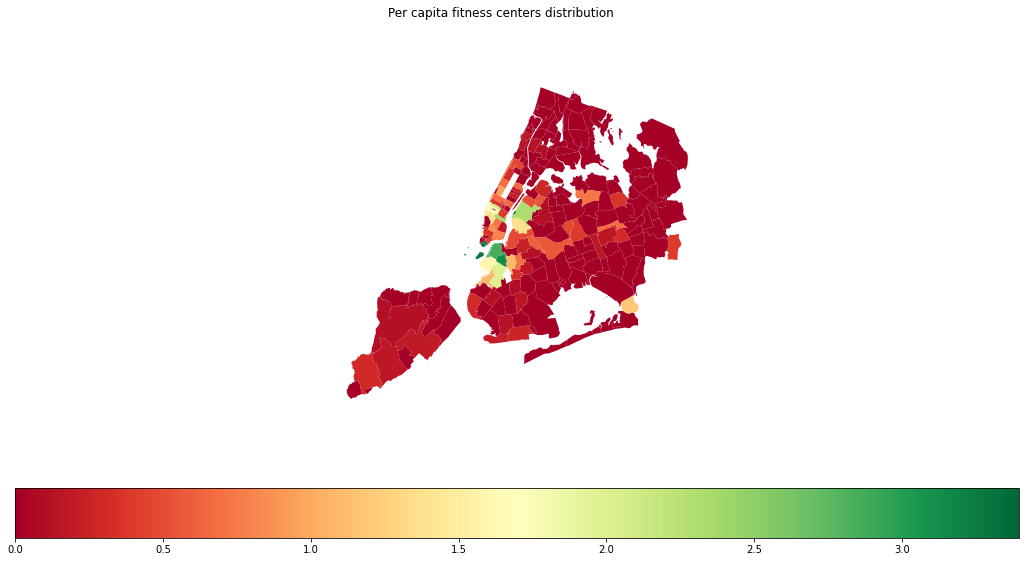

In [264]:
fig1, ax = plt.subplots(figsize = (18, 9))
final_table.plot(ax = ax, column = 'per_capita_fitness', cmap = 'RdYlGn', legend = True,  legend_kwds = {'orientation':'horizontal'})
fig1.suptitle("Per capita fitness centers distribution")
ax.set_axis_off()
plt.show()


Let's visualize median age per zip code to see the distribution.

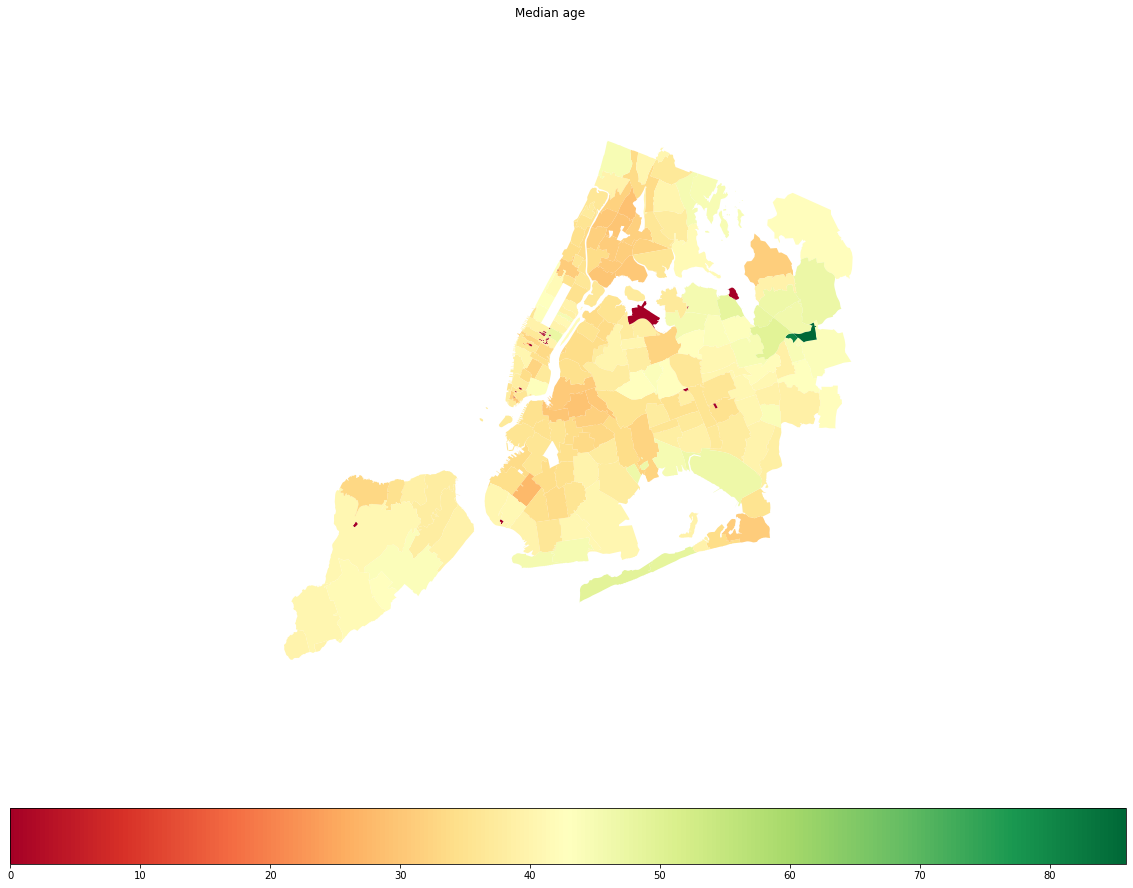

In [159]:
fig2, ax = plt.subplots(figsize = (20, 15))
final_table.plot(ax = ax, column = 'median_age', cmap = 'RdYlGn', legend = True, legend_kwds = {'orientation':'horizontal'})
fig2.suptitle("Median age")
ax.set_axis_off()
plt.show()

Median age turned to be not so insightful in this case. 
Earlier we cited [a statistical report](https://runrepeat.com/gym-membership-statistics) about gym membership. According to that report  ~61% of fitness atendees belong to the age groups: 18_34 and 35_54, ~60% have an income higher than 75K and ~87% belong to the white/black or hispanic races. So, we will consider the population of the mentioned categories as our target group and will add corresponding variables to the final table.

In [221]:
final_table['target_age_group'] = final_table['total_18_34'] + final_table['total_35_54']
final_table['target_income_group'] = final_table['income_60000_99999'].astype(float) + final_table['income_100000_149999'].astype(float) + final_table['income_150000_more'].astype(float)
final_table['target_race_group'] = final_table['hispanic_latinx'] + final_table['black'] + final_table['white']

First, let's see the correlation between these new variables. We will filter zip codes with at least one existing fitness center.

In [190]:
bubble = px.scatter(final_table[final_table['fitness_centers_count']>0.0], x="target_age_group", y="target_income_group", 
                    size = "fitness_centers_count", color = 'target_race_group',
                    log_x=True, size_max=60)
bubble.show()

Indeed, we can see an overall positive correlation among them: the higher the number of people in our target age and income groups the more the number of fitness centers. 

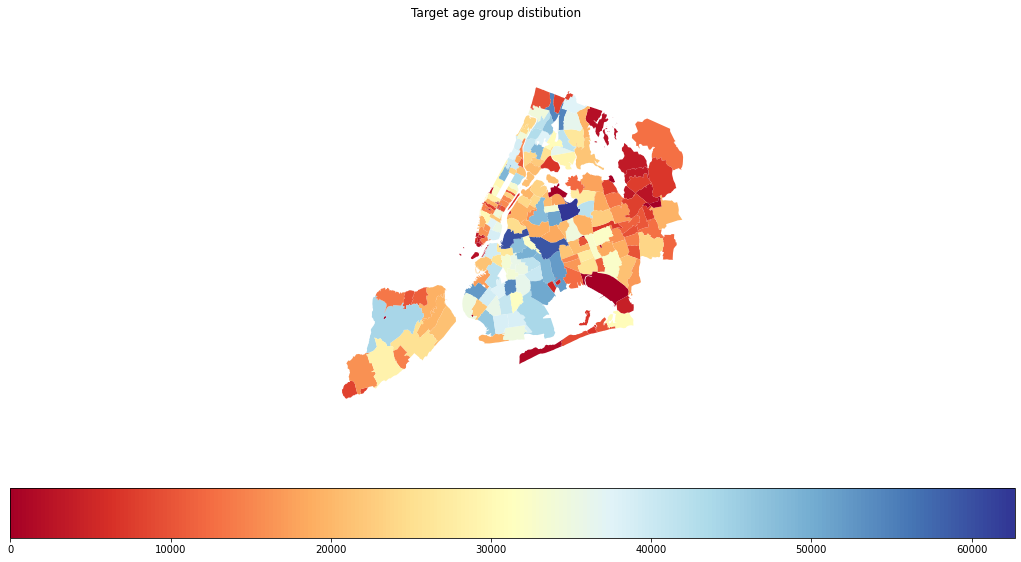

In [265]:
fig3, ax = plt.subplots(figsize = (18, 9))
final_table.plot(ax = ax, column = 'target_age_group', cmap = 'RdYlBu', legend = True, legend_kwds = {'orientation':'horizontal'})
fig3.suptitle("Target age group distibution")
ax.set_axis_off()
plt.show()

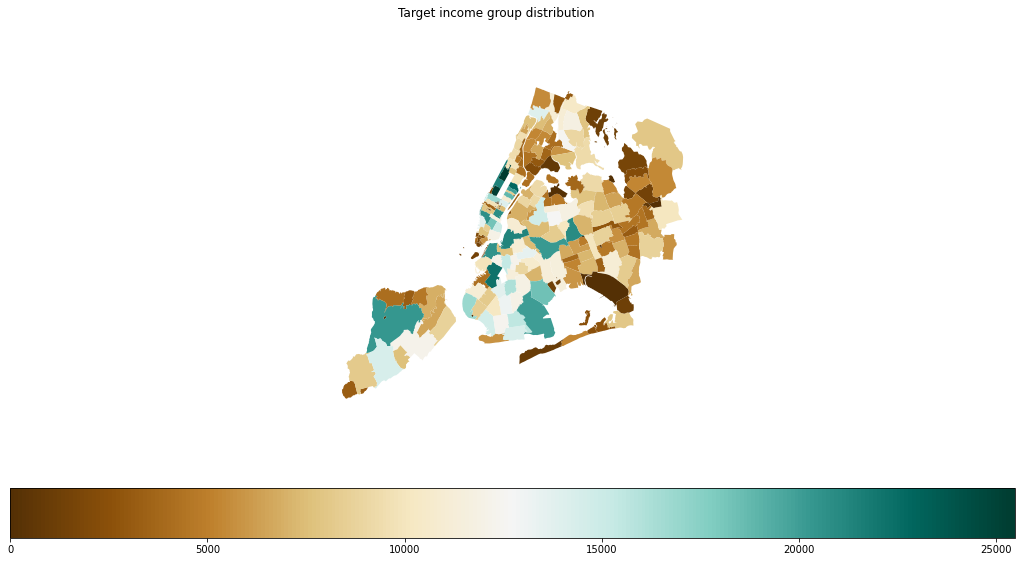

In [266]:
fig4, ax = plt.subplots(figsize = (18, 9))
final_table.plot(ax = ax, column = 'target_income_group', cmap = 'BrBG', legend = True, legend_kwds = {'orientation':'horizontal'})
fig4.suptitle("Target income group distribution")
ax.set_axis_off()
plt.show()

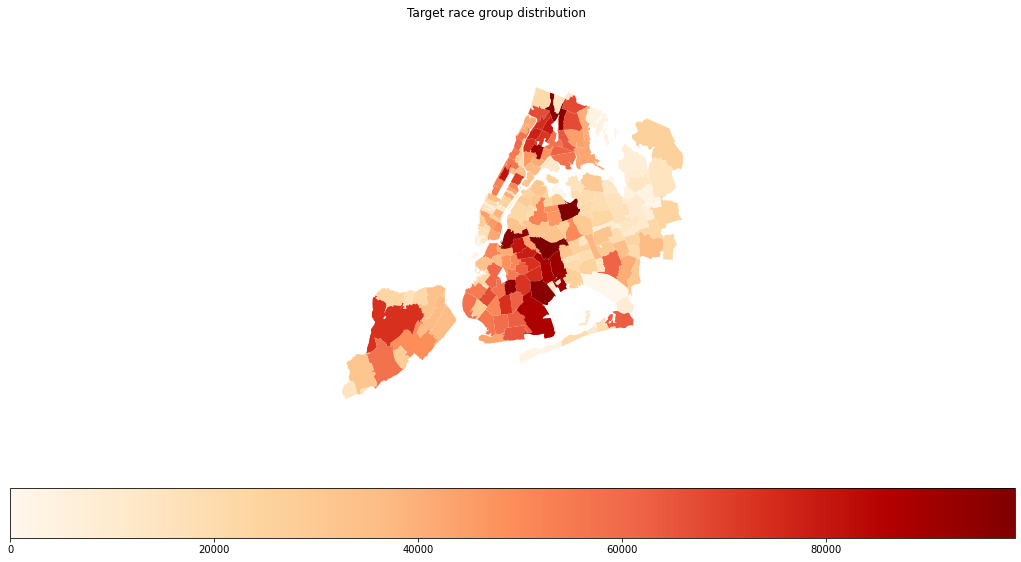

In [267]:
fig5, ax = plt.subplots(figsize = (18, 9))
final_table.plot(ax = ax, column = 'target_race_group', cmap = 'OrRd', legend = True, legend_kwds = {'orientation':'horizontal'})
fig5.suptitle("Target race group distribution")
ax.set_axis_off()
plt.show()

Now let's create another bubble chart to find out a few key neighborhoods that satisfy our 'target group' filtering. We will narrow the number of zip codes even more by extra conditions: 

*   the number of fitness centers is 1 or smaller, 
*   the population of target age group is at least 20K

Then we will select the onew with the highest number of target income group

In [ ]:
target_table = final_table[final_table['fitness_centers_count']<=1.0][final_table['target_age_group']>=20000].sort_values(by = 'target_income_group', ascending = False).head(25)

In [280]:
bar = px.bar(target_table[["neighborhood", "target_income_group", "zip_code"]], x = "neighborhood", y="target_income_group", color = "target_income_group",
                     hover_name = "zip_code")
bar.show()

In [249]:
target_table[['zip_code', 'neighborhood', 'target_age_group', 'target_income_group', 'target_race_group']].sort_values(by = 'target_income_group', ascending = False).head(25)

,zip_code,neighborhood,target_age_group,target_income_group,target_race_group
184,10314,Mid-Island,44258,20306.0,73774
165,11234,Canarsie and Flatlands,44059,20060.0,87622
177,10028,Upper East Side,26872,20044.0,42613
220,10021,Upper East Side,23224,18841.0,40577
176,11236,Canarsie and Flatlands,50521,18390.0,95995
175,11226,Flatbush,54327,16133.0,94727
24,11229,Southern Brooklyn,38566,15619.0,62978
114,10009,Lower East Side,35678,15108.0,48960
14,11377,West Queens,48124,14761.0,52631
73,11214,Southwest Brooklyn,46510,14646.0,56092


We can see that among the neighborhoods with a potential demand for fitness centers are 

*   Mid-Island
*   Canarsie and Flatlands
*   Upper East Side		
*   Flatbush	
*   Southern Brooklyn	
*   Lower East Side	
*   West Queens
*   South Shore	
*   Kingsbridge and Riverdale
*   Borough Park	
*   Bushwick and Williamsburg	
*   Southeast Bronx
*   Southern Brooklyn	38489
*   Northeast Bronx	
*   East New York and New Lots	
